In [1]:
import tangos
import pynbody
import pynbody.analysis.gravity

import numpy as np
import pandas as pd

from astropy.io import fits

import matplotlib.pyplot as plt

import glob
import math

import sys
sys.path.insert(0, '../util/')
from util import util
import mpfit

import scipy.optimize
from lmfit import Model

## Outline
1) load data and scale
2) fit gauss-hermite polynomial with h3 term 
3) subtract vrot at each spatial pixel 
4) do line 

# 1) Load Data

In [2]:
haloIDs = [431, 468, 492, 502, 523, 569]

In [3]:
def getfilepath(h):
    '''
    gets file path for data of halo h in [CDM, SIDM] order 
    '''
    
    cdm = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r'+str(h)+'.romulus25.3072g1HsbBH/r'+str(h)
    cdm += '.romulus25.3072g1HsbBH.004096'
    
    sidm = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r'+str(h)+'.romulus25cvdXsec.3072g1HsbBH/r'+str(h)
    sidm +='.romulus25cvdXsec.3072g1HsbBH.004096'
    
    return [cdm,sidm]

In [4]:
i=2
fpath = getfilepath(haloIDs[i])
h1files = glob.glob(fpath[0]+'/*.fits')
h1files.sort()
if len(h1files) == 4: h1files = h1files[1:]

In [5]:
# set halo and get file 
#i = 2
#file = getfilepath(haloIDs[i])[1]+'/r'+str(haloIDs[i])+'.alfalfa_hi.x.fits'

# load data 
f = fits.open(h1files[0], do_not_scale_image_data=True)
bscale = f[0].header['BSCALE']
bzero = f[0].header['BZERO']
blank = f[0].header['BLANK']
data = f[0].data

vstart = f[0].header['CRVAL3']
dv = f[0].header['CDELT3']
D = 70 #mpc 

# initial scaling 
data = data * bscale + bzero
data = np.power(np.full(data.shape,10), data)
data[np.where(abs(data - 10**(blank*bscale + bzero))<10e-5)]=0.0

# convert from solar mass to Jy (el bhadri et al 2018 for mock obs at 70 MPC)
S = data
#S = (1/(2.36e5))*(data)*(dv**-1)*(D**-2)

Text(0, 0.5, 'Flux density [Jy]')

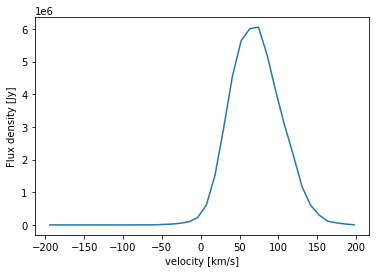

In [6]:
# a line of sight spectra is data[:,x,y]
xaxis = np.arange(vstart, vstart+(dv*len(S[:,26,26])), dv)
plt.plot(xaxis,S[:,26,26])
plt.xlabel('velocity [km/s]')
plt.ylabel('Flux density [Jy]')

# Fit with Guass Hermite and shift

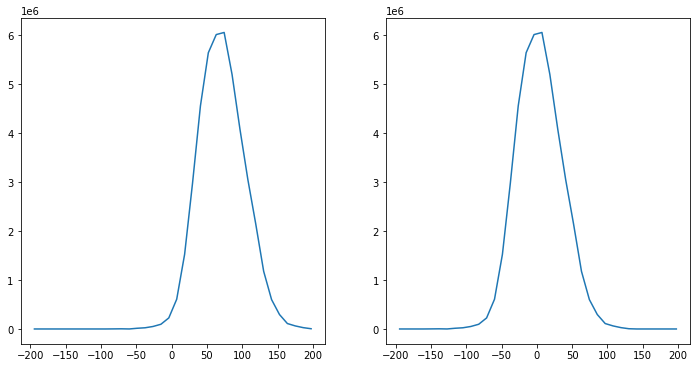

In [7]:
arr = np.copy(S[:,26,26])
vmax = xaxis[np.where(arr == arr.max())][0]
arr2 = np.copy(arr)
arr2 = np.roll(arr2, math.ceil(-vmax/dv))
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].plot(xaxis,arr)
axs[1].plot(xaxis,arr2)

In [8]:
# vmax without fit 
pixel = S[:,26,26]
vmax = xaxis[np.where(pixel == pixel.max())][0]
xaxis = xaxis - vmax

In [9]:
def gaussHermite(x, A, s, h, mu):
    y = (x-mu)/s
    outside = A*np.exp((-1*np.power(y,2))/2)
    inside = 1 + (h/np.sqrt(6))*(2*np.sqrt(2)*np.power(y,3) - 3*np.sqrt(2)*y)
    return outside*inside

In [10]:
# do fit 
i=25
j=25
maxval = S[:,i,j].max()
p0 = [maxval, 10, 0, xaxis[np.where(S[:,i,j]==maxval)][0]]
p,_ = scipy.optimize.curve_fit(gaussHermite, xaxis, S[:,i,j], maxfev=100000, p0=p0)


# with lmpy 
ghmodel = Model(gaussHermite)
#result = ghmodel.fit(S[:,26,26], x=xaxis)

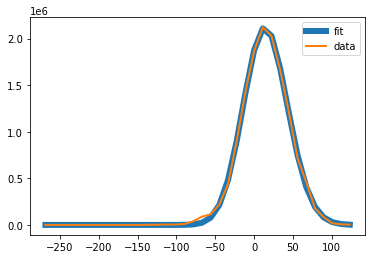

In [11]:
plt.plot(xaxis, gaussHermite(xaxis, p[0],p[1],p[2],p[3]), linewidth=6)
plt.plot(xaxis, S[:,i,j], linewidth=2)
plt.legend(['fit', 'data'])

In [12]:
# let's iterate through all pixels and do this; then sum into HI profile 
for i in range(len(S[0,:,0])):
    for j in range(len(S[0,0,:])):
        xaxis = np.arange(vstart, vstart+(dv*len(S[:,i,j])), dv)
        # get naive vmax
        vmax = xaxis[np.where(S[:,i,j] == S[:,i,j].max())][0]
        
        # do fit 
        if max(S[:,i,j]) >10:
            maxval = S[:,i,j].max()
            p0 = [maxval, 10, 0, xaxis[np.where(S[:,i,j]==maxval)][0]]
            p,_ = scipy.optimize.curve_fit(gaussHermite, xaxis, S[:,i,j], maxfev=100000, p0=p0)
            fity = gaussHermite(xaxis, p[0],p[1],p[2],p[3])
            vmaxfit = xaxis[np.where(fity == fity.max())][0]
        
            # shift array such that vmax is over zero
            S[:,i,j] = np.roll(S[:,i,j], math.ceil(-vmaxfit/dv))
        
# Take sum 
hiprof = np.sum(np.sum(S,1),1)

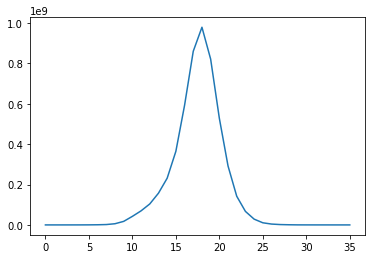

In [13]:
plt.plot(hiprof)

# Fit Super profile with Gaussian

In [27]:
def gaussian(x, A, mu, s):
    return (A/(s*np.sqrt(2*np.pi))) * np.exp((-1*np.power(x-mu,2))/(2*np.power(s,2)))

In [62]:
p0 = [max(hiprof), 0, 100]
p,_ = scipy.optimize.curve_fit(gaussian, xaxis, hiprof, maxfev=100000, p0=p0)

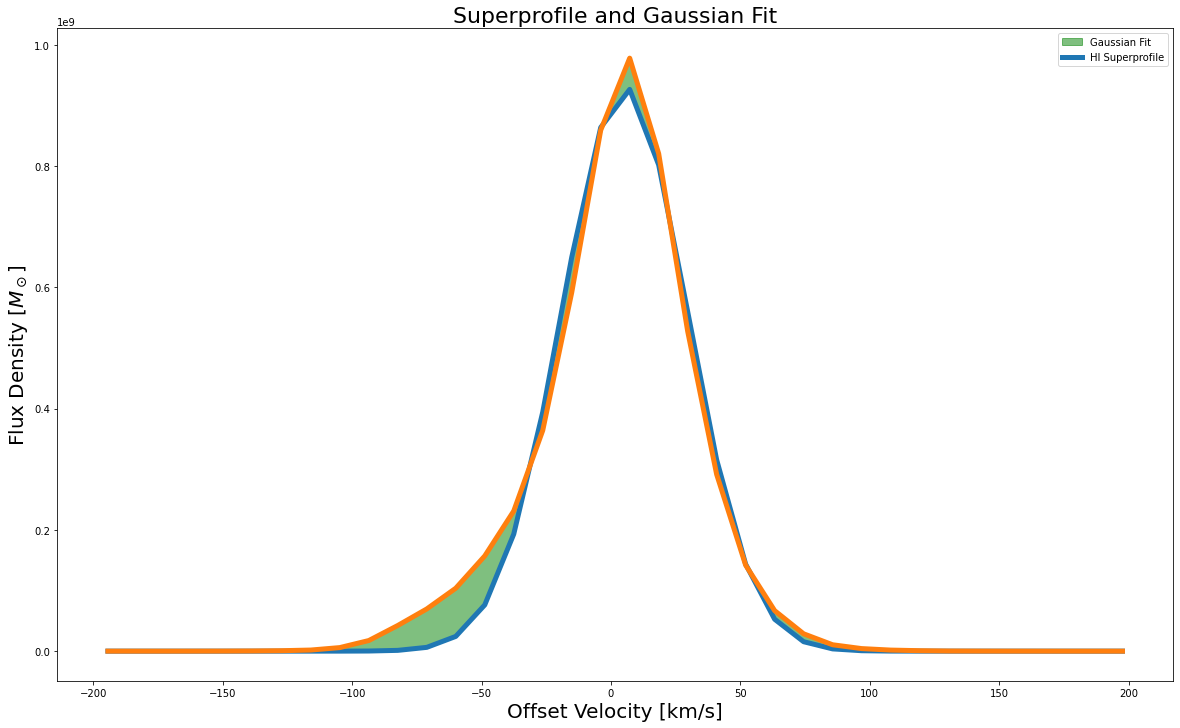

In [63]:
fig = plt.figure(figsize=(20,12))

g = gaussian(xaxis, p[0],p[1],p[2])

plt.fill_between(xaxis, hiprof, g, color='g', alpha=0.5)

plt.plot(xaxis, g, linewidth=5)
plt.plot(xaxis, hiprof, linewidth=5)

# prettify 
plt.title('Superprofile and Gaussian Fit', fontsize=22)
plt.xlabel('Offset Velocity [km/s]', fontsize=20)
plt.ylabel(r'Flux Density [$M_\odot$]', fontsize=20)
plt.savefig('ExampleSuperprofile.png')

plt.legend(['Gaussian Fit', 'HI Superprofile'])

In [39]:
p0

[978205435.9304407, 0, 50]

In [40]:
gaussian(xaxis, p[0],p[1],p[2])

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 3.76224825e-164,
       4.10004054e-058, 1.48671951e-006, 1.79378391e-009, 7.20130815e-067,
       9.61950793e-179, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000])